Load dependencies

In [11]:
MARKERS = ['CD79B', 'MAP2K3', 'IMPDH1', 'SLC16A3', 'MPZL3', 'APOBR']

Load dependencies

In [12]:
import sklearn
from sklearn.neighbors import BallTree
import scipy
from scipy.spatial import distance
from scipy.stats import zscore
import sys
import numpy as np
import pandas as pd
import lifelines
from lifelines import KaplanMeierFitter

sys.path.append('/Users/matthewbernstein/Development/single-cell-hackathon/Identifying-bulk-RNA-seq-derived-biomarkers-of-cancer-risk-within-single-cell-populations/src/common')

import load_TCGA_GBM
import load_GSE103224
import normalize
import slice_matrix

Retrieve and normalize the TCGA bulk RNA-seq data

In [13]:
# Retrieve counts matrix
X, samples = load_TCGA_GBM.counts_matrix()
X = slice_matrix.keep_genes(
    X, 
    load_TCGA_GBM.GENE_NAMES, 
    MARKERS
)

# Normalize
X = normalize.log_cpm(X)

# Compute x-scores
X = zscore(X)

# Make sure the metadata and matrix are aligned
assert tuple(load_TCGA_GBM.SAMPLE_IDS) == tuple(load_TCGA_GBM.TCGA_GBM_META['sample_id']) 

X.shape

(147, 6)

Compute the sum of the z-scores for each tumor and compute the top and bottom quantiles

In [14]:
scores = np.sum(X, axis=1)

up_q = 0.6 # Top quantile
low_q = 0.4 # Bottom quantile
high = np.quantile(scores, up_q)
low = np.quantile(scores, low_q)

Partition data into top and bottom quantile

In [15]:
df = load_TCGA_GBM.TCGA_GBM_META
df_scores = pd.DataFrame(
    data=[
        (sample, score) 
        for sample,score in zip(load_TCGA_GBM.SAMPLE_IDS, scores)
    ],
    columns=['sample_id', 'score']
)
df_scores = df_scores.set_index('sample_id')
df = df.set_index('sample_id')
df = df.join(df_scores, on='sample_id', how='left')


df_high = df.loc[df['score'] > high]
df_low = df.loc[df['score'] <= low]

Plot Kaplan-Meier curves

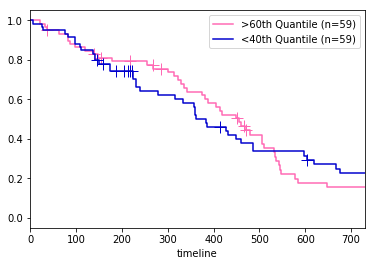

In [16]:
kmf = KaplanMeierFitter()
kmf.fit(
    df_high['time'],
    df_high['censor'],
    label='>{}th Quantile (n={})'.format(int(up_q * 100), len(df_high))
)
ax = kmf.plot(ci_show=False, show_censors=True, color='hotpink', ls='-')
kmf.fit(
    df_low['time'],
    df_low['censor'],
    label='<{}th Quantile (n={})'.format(int(low_q * 100), len(df_low))
)
ax = kmf.plot(ci_show=False, show_censors=True, ax=ax, color='mediumblue', ls='-')
ax.set_xlim((0,730))
ax